CS524: Introduction to Optimization Lecture 27
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison

## November 6, 2023
--------------

# LQR control: a structured QP

$$
\min \int_0^1 6 u(t)^2 + 2x_1(t)^2 + x_2(t)^2 \, \mbox{d}t,
$$
$$ 
\begin{bmatrix} \dot{x_1} \\
\dot{x_2} \end{bmatrix} = 
\begin{bmatrix} x_2 \\ -x_1 + u \end{bmatrix},
$$
$$
|u(t)| \le U, \;\; x_1(0) = 15, \;\; x_2(0) = 5,
$$

where $U$ is a positive constant.  Start with a linear ODE and its
solution, introduce concept of an input/control $u$ that influences
the evolution of the ODE, objective function and constraints to guide
$x$ to a particular goal.

# Euler discretization

We use Euler discretization to model the derivatives:
$$ \dot{x} = 
\frac{x^{t+1} - x^t}{\delta t} 
$$

$$
\dot{x} = Ax+Bu
$$
$$ \frac{x_1^{t+1}-x_1^t}{\delta t} = x_2^t
$$
$$ \frac{x_2^{t+1}-x_2^t}{\delta t} = -x_1^t+u^t
$$
leads to
$$ \frac{x^{t+1}-x^t}{\delta t} = Ax^t+Bu^t
$$

Read in data and plot.
Push data into gams environment.

In [1]:
%load_ext gams.magic
m = gams.exchange_container
# Set the number of stages and control bound to the desired value 
T = 200
stages = m.addSet('stages',records=range(0,T+1))
U = m.addParameter('Ubound',records=0.1)

Discuss the structure and detail the QP. 

We approximate the integral using the trapezoidal rule (see https://en.wikipedia.org/wiki/Trapezoidal_rule).

In [2]:
%%gams
option limrow=20, limcol=0, solprint=off;

$eval T card(stages)-1
set states /1*2/;
set inputs /1/;

alias (states,n); alias (inputs,m);

parameter
  Xinitial(states)        initial X /1  15, 2  5/;

scalar deltaT;

* set interval width deltaT to be 1/T.
deltaT = 1.0 / %T%;

variable
  x(stages, states)   "state variables",
  u(stages, inputs)   "input variables (controls)",
  cost                "objective function";

table Q(states,states) 'Hessian wrt states'
     1     2
1   2.0   0.0
2   0.0   1.0;

table R(inputs,inputs) 'Hessian wrt inputs'
     1
1   6.0;

table A(states,states) 'state transition matrix in continuous formulation'
    1    2
1  0.0  1.0
2 -1.0  0.0;

table B(states,inputs) 'input transition matrix in continuous formulation'
   1
1  0.0
2  1.0;

equations
  state(stages, states) 'state transition equation'
  objective             'cost function';

state(stages, states)$(ord(stages) < card(stages))..
    (x(stages+1, states) - x(stages, states) ) / deltaT
          =e= sum(n, A(states, n)*x(stages,n))
             +sum(m, B(states, m)*u(stages,m));

* objective includes a numerical integral over [0,1], using Trapezoidal rule
objective..
    cost =e= (1/2) * deltaT *
       ( sum(stages$(ord(stages) < card(stages)),
           sum((states,n), x(stages,states)*Q(states,n)*x(stages,n))
           + sum((inputs,m), u(stages,inputs)*R(inputs,m)*u(stages,m)) )
        + sum(stages$(ord(stages) > 1),
            sum((states,n), x(stages,states)*Q(states,n)*x(stages,n))
            + sum((inputs,m), u(stages,inputs)*R(inputs,m)*u(stages,m)) )
       )
;

* fix the initial values
x.fx('0',states) = Xinitial(states);

* fix lower and upper bounds
u.up(stages, inputs) =  Ubound; u.lo(stages, inputs) = -Ubound;

* fix final control
u.fx(stages, inputs)$(ord(stages) eq card(stages)) = 0;

model lqr/all/;

Look at the sparsity pattern of the model.

First dump out the Jacobian and Hessian using the convert tool.
Then read this into python and plot using scipy and matplotlib

In [3]:
%%gams
$onecho > convert.opt
DumpGDX jac.gdx
GDXHessian 1
$offecho

option qcp = convert;
lqr.optfile = 1;
# to ensure see all coeffs in Jacobian
x.l(stages,states) = 0.01;
u.l(stages,inputs) = 0.01;
solve lqr using qcp min cost;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),NoSolutionReturned (14),0.0,401,604,QCP,CONVERT,0.005


Point out the structure of the Hessian and constraint matrices.

Plot out the Jacobian of the constraint matrix.
x variables are first, followed by u variables.
Note that objective row is the last row in this plot.

See the block diagonal form of the constraint matrix.

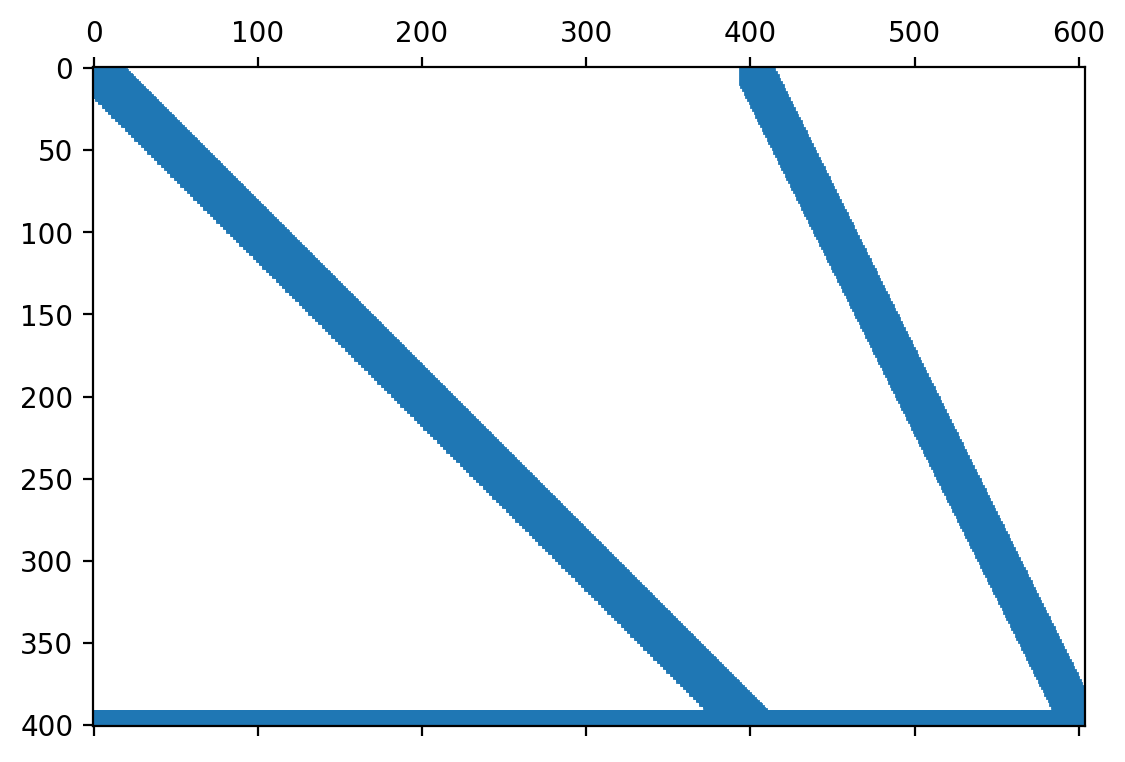

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import gams.transfer as gt
import scipy.sparse as sps

gdxin = gt.Container()
# must read in domain of A as well
gdxin.read('jac.gdx',['A','i','j','H'])
M = gdxin['A'].toSparseCoo()
plt.spy(M)
plt.show()

We can extract the Hessian for each row of this constraint matrix, but since all except last row are zero matrices (since these constraints are linear). 
 
We extract that Hessian of the objective row and see below that the hessian $H$ is diagonal. 

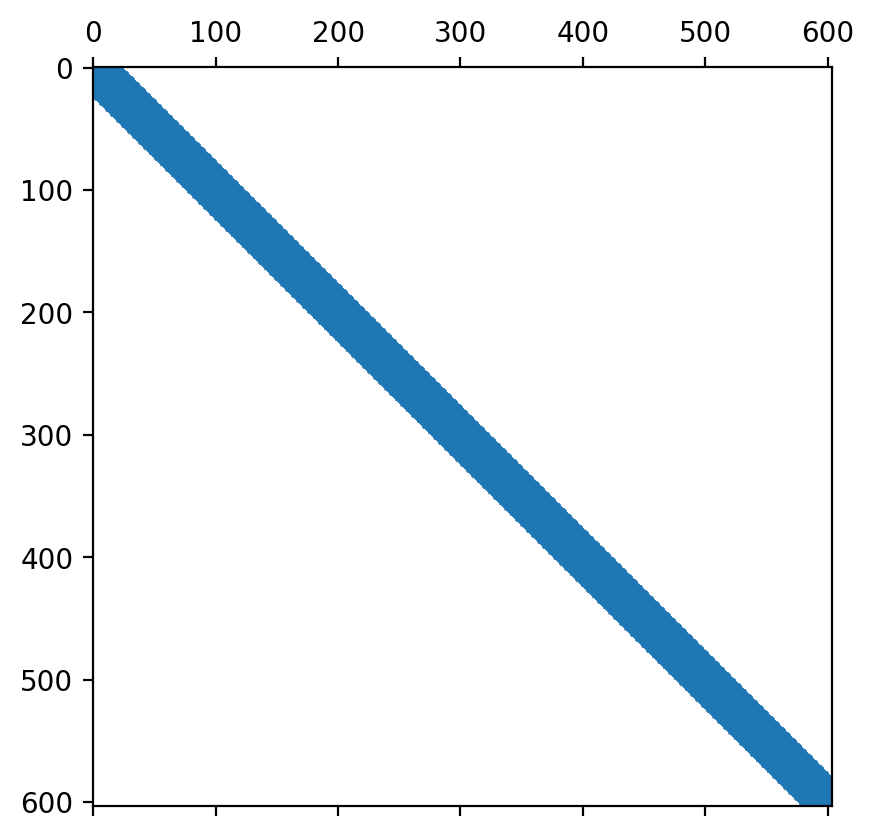

In [5]:
# Hessian is for each row, drop first index and plot
Hess=gdxin['H']
Hess.domain = Hess.domain[1:3]
Hess.records.drop(columns='i_0',inplace=True)
Hess.records.columns=['j_0','j_1','value']
H = Hess.toSparseCoo()
plt.spy(H)
plt.show();

Now run real model.   

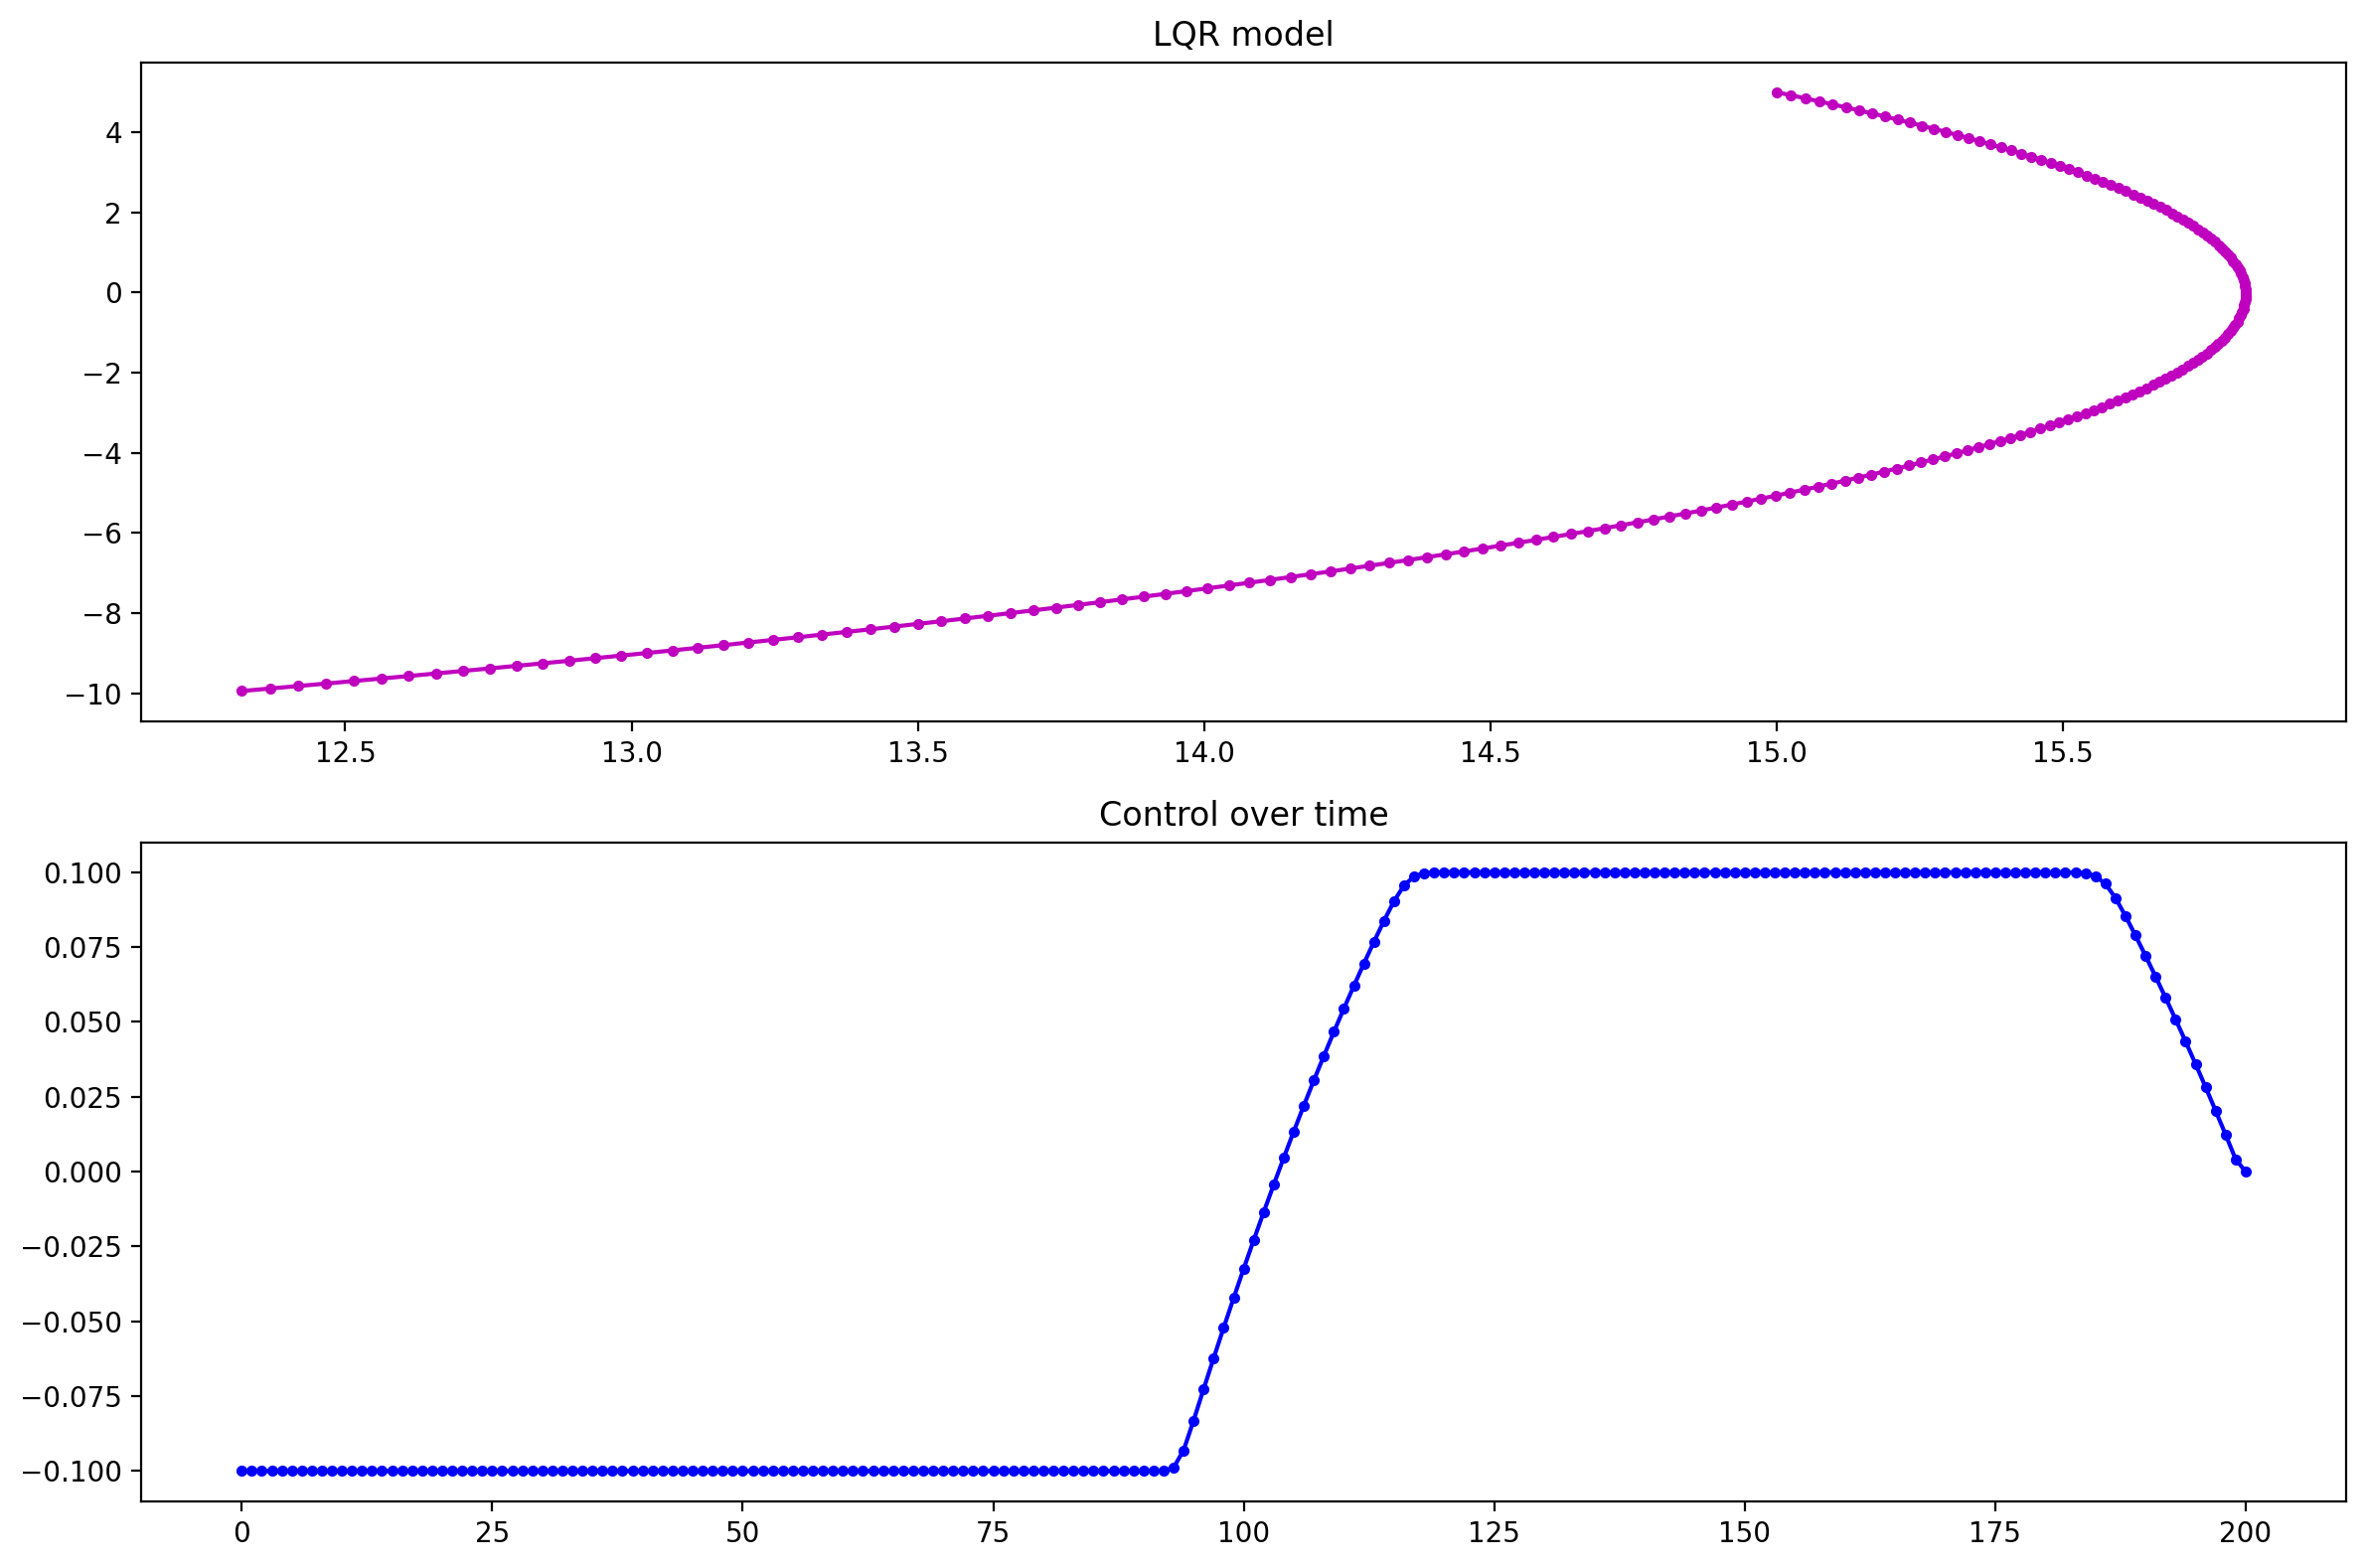

In [6]:
gams.gams('option qcp = cplex; lqr.optfile=0; solve lqr using qcp minimizing cost;')

cost = m['cost'].toValue()
x = m['x'].pivot()
u = m['u'].pivot()

fig, ax = plt.subplots(nrows=2,figsize=(12,8))
# plot the x data
ax[0].plot(x['1'],x['2'],'m.-')
ax[0].set_title("LQR model")
ax[1].plot(range(0,T+1),u['1'],"b.-")
ax[1].set_title("Control over time")
fig.tight_layout();

Could also update value of U (0.2, 0.5, etc)

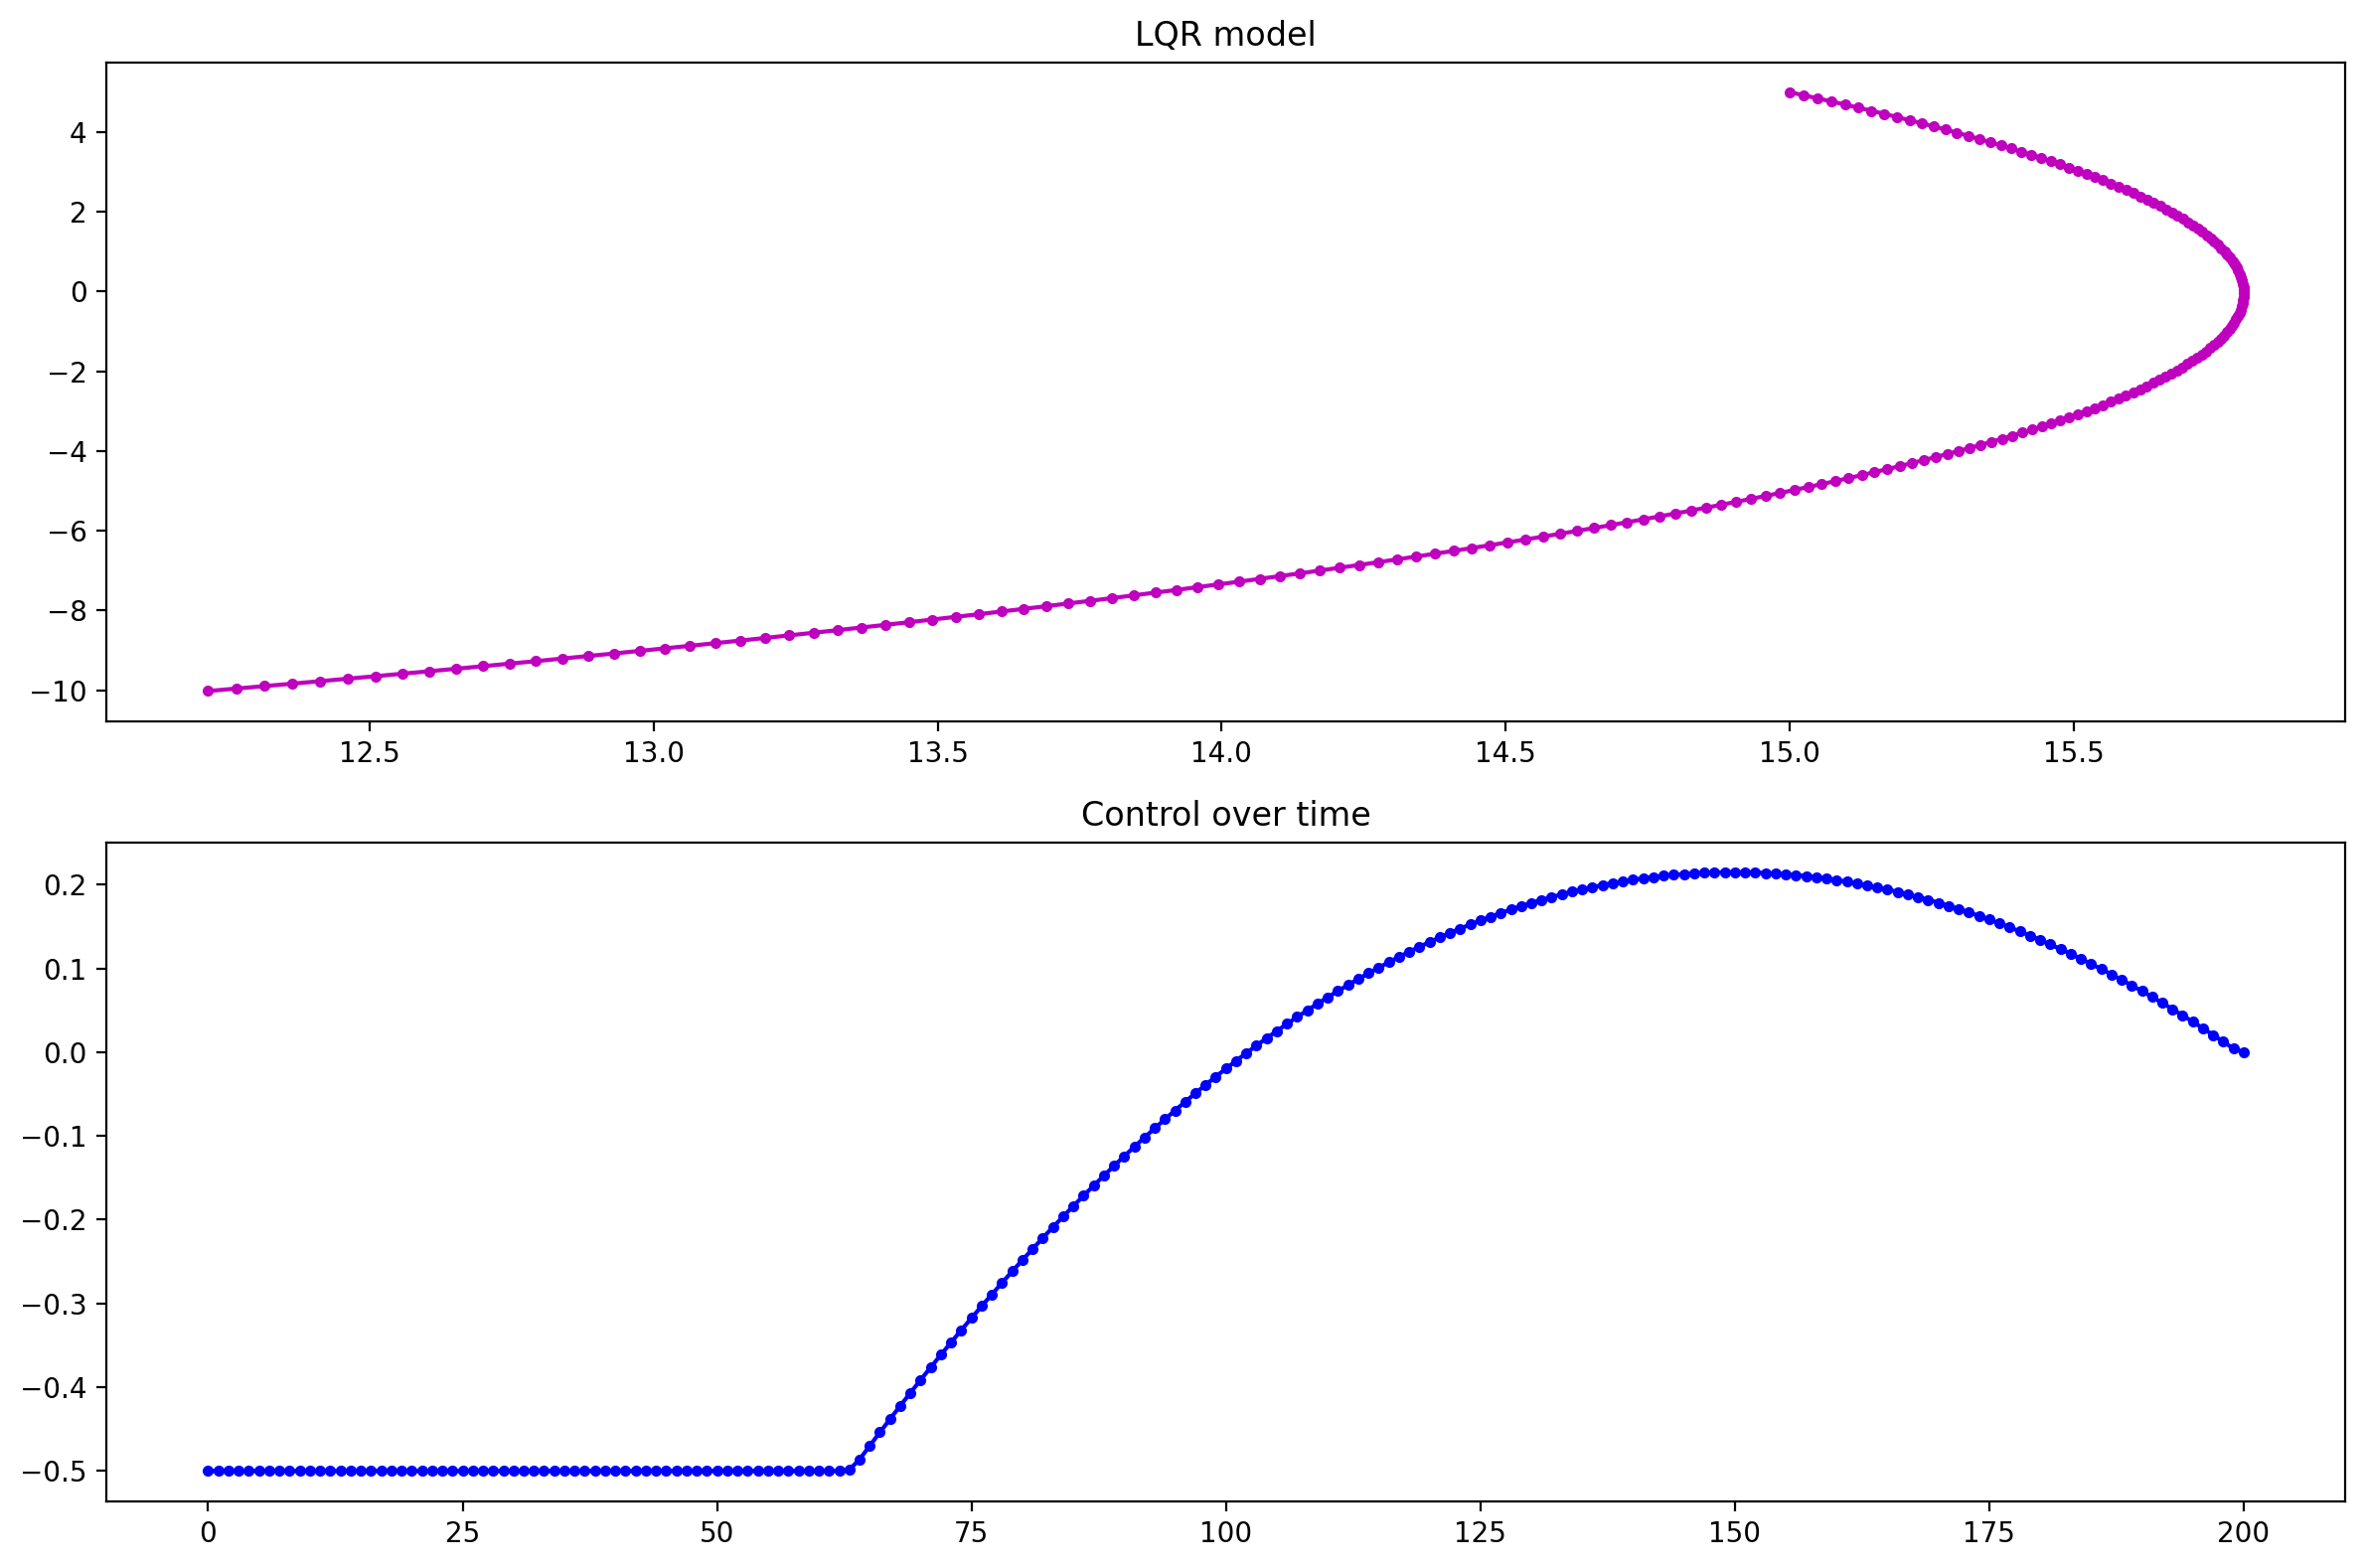

In [7]:
U.setRecords(0.5)
# to fix bug in interface
U.modified = True

# fix of =-U instead if = -U
gams.gams('display Ubound; u.up(stages, inputs) = Ubound; u.lo(stages, inputs) =-Ubound; solve lqr using qcp minimizing cost;')

cost = m['cost'].toValue()
x = m['x'].pivot()
u = m['u'].pivot()

fig, ax = plt.subplots(nrows=2,figsize=(12,8))
# plot the x data
ax[0].plot(x['1'],x['2'],'m.-')
ax[0].set_title("LQR model")
ax[1].plot(range(0,T+1),u['1'],"b.-")
ax[1].set_title("Control over time")
fig.tight_layout();

In [8]:
%gams_cleanup --closedown